# Сжатие картинок с помощью SVD разложения
В этом задании нужно сделать сжатие изображения, сжатие с потерями. Для этого мы используем SVD разложение.

Примерный порядок действий:
1) Найти любую картинку,
2) Прочитать её с помощью библиотеки PIL
3) Преобразовать в numpy массив
4) Применить SVD к матрице - обязательно прочитайте справку по этой функции `np.linalg.svd`

**Примечание**: Цветная картинка представляет собой трёхканальное изображение RBG, поэтому напрямую SVD разложение применить не получится. Либо вы преобразуете изображение в одноканальное (градации серого), усредняя все три канала. Либо делаете SVD для всех трёх каналов в отдельности.

5) Далее оставляете небольшое количество сингулярных значений - 1, 2, 10, 30, 100. И выводите результат в виде получившейся картинки - чем больше сингулярных чисел, тем ближе приближённая матрица к исходной.

6) Сравните количество байт, необходимых для хранения исходной картинки и сжатой версии.

Ниже представлены основные функции и библиотеки, которые вам понадобятся.

Задание оформляете в виде блокнота jupyter. Особо понравившиеся картинки можно сохранить отдельно на диск, но мне удобнее чтобы они присутствовали в самом jupyter блокноте.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


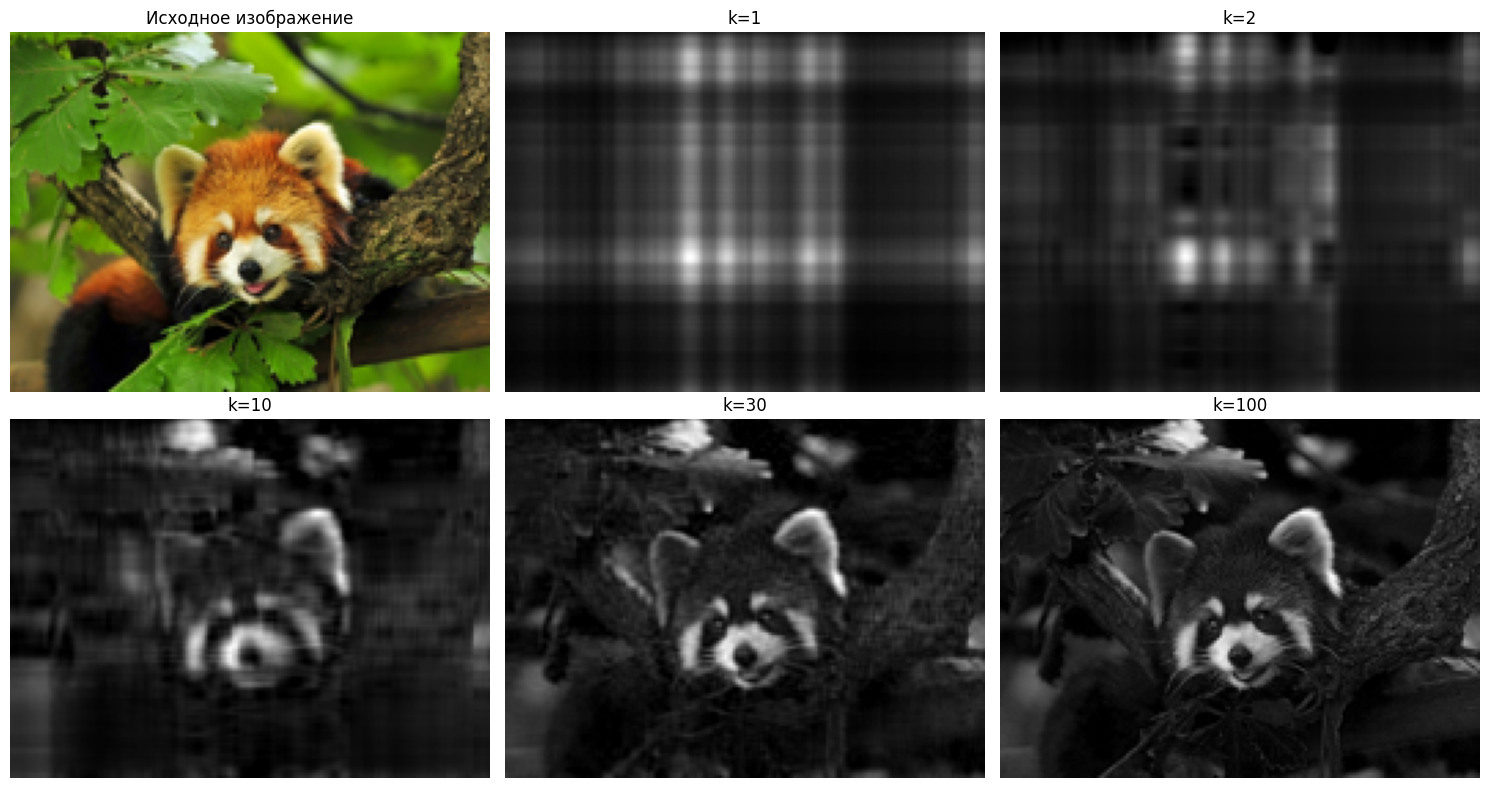

Исходный размер (байты): 68775


ValueError: too many values to unpack (expected 2)

In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('panda.jpg')
w, h = img.size
img = img.resize((w//4, h//4)) # можно не делать .resize(())



A = np.array(img)  # Получение массива изображения
# Если изображение цветное, разделите по каналам
channels = []
for i in range(A.shape[2]):  # для каждого цветового канала
    channel = A[:, :, i]
    U, S, VT = np.linalg.svd(channel, full_matrices=False)
    k = 1  # число компонент
    channel_compressed = np.dot(U[:, :k], np.diag(S[:k])).dot(VT[:k, :])
    channel_compressed = np.clip(channel_compressed, 0, 255)
    channels.append(channel_compressed)
# Объедините каналы обратно
A_compressed = np.stack(channels, axis=2).astype(np.uint8)
# Создайте изображение из массива
compressed_img = Image.fromarray(A_compressed)
compressed_img.show()




def reconstruct_image(k): # Функция для восстановления изображения с определенным количеством сингулярных чисел
    A_k = np.dot(U[:, :k], np.diag(S[:k])).dot(VT[:k, :])
    A_k = np.clip(A_k, 0, 255)
    return Image.fromarray(A_k.astype(np.uint8))

k_values = [1, 2, 10, 30, 100] # Количество сингулярных значений

plt.figure(figsize=(15, 8)) # Построение изображений и сравнение с исходным
plt.subplot(2, 3, 1)
plt.imshow(A, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

for i, k in enumerate(k_values, start=2):
    img_recon = reconstruct_image(k)
    plt.subplot(2, 3, i)
    plt.imshow(img_recon, cmap='gray')
    plt.title(f'k={k}')
    plt.axis('off')

plt.tight_layout()
plt.show()

original_bytes = A.size # Размер исходного изображения в байтах
print(f"Исходный размер (байты): {original_bytes}")

m, n = A.shape # Размер сжатого хранения у подписи SVD:  U (m x k), S (k), VT (k x n)
size_U = U[:, :max(k_values)].shape[0] * max(k_values) * 8
size_S = max(k_values) * 8
size_VT = VT[:max(k_values), :].shape[0] * n * 8

# Для каждого k рассчитываем размеры отдельно
for k in k_values:
    size_U_k = m * k * 8
    size_S_k = k * 8
    size_VT_k = k * n * 8
    total_size_k = size_U_k + size_S_k + size_VT_k
    ratio = original_bytes / total_size_k
    print(f"k={k}:")
    print(f"  Размер хранения (байты): {total_size_k}")
    print(f"  Коэффициент сжатия: {ratio:.2f}")

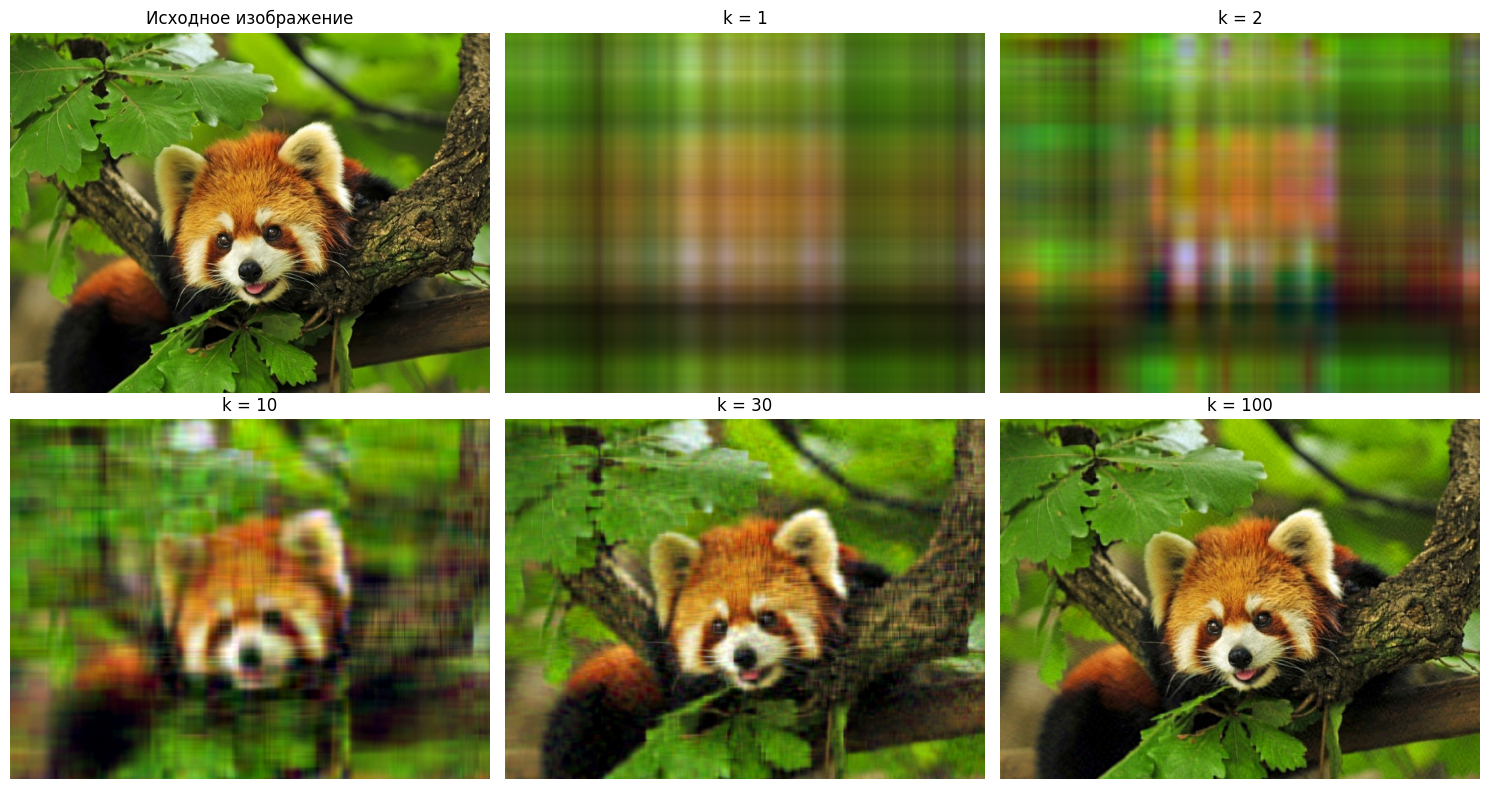

Исходный размер (байты): 1102500
k = 1:
  Размер хранения (байты): 9808
  Коэффициент сжатия: 112.41
k = 2:
  Размер хранения (байты): 19616
  Коэффициент сжатия: 56.20
k = 10:
  Размер хранения (байты): 98080
  Коэффициент сжатия: 11.24
k = 30:
  Размер хранения (байты): 294240
  Коэффициент сжатия: 3.75
k = 100:
  Размер хранения (байты): 980800
  Коэффициент сжатия: 1.12


In [9]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('panda.jpg')
w, h = img.size
A = np.array(img)

if A.ndim == 3: # Проверим, цветное ли изображение
    channels = []
    U_matrices = []
    S_vectors = []
    VT_matrices = []
    for i in range(A.shape[2]):  # для каждого цветового канала
        channel = A[:, :, i]
        U, S, VT = np.linalg.svd(channel, full_matrices=False)  # Выполняем SVD для канала
        channels.append(channel)
        U_matrices.append(U)
        S_vectors.append(S)
        VT_matrices.append(VT)

def reconstruct_image(k): # функция для восстановления изображения по размещенным компонентам
    if A.ndim == 3:
        channels_reconstructed = [] # Восстановление цветного изображения
        for i in range(A.shape[2]):
            U = U_matrices[i]
            S = S_vectors[i]
            VT = VT_matrices[i]
            A_k = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
            A_k = np.clip(A_k, 0, 255)
            channels_reconstructed.append(A_k.astype(np.uint8))
        return Image.fromarray(np.stack(channels_reconstructed, axis=2))
    else:
        # Для градационных изображений
        U = U_matrices[0]
        S = S_vectors[0]
        VT = VT_matrices[0]
        A_k = U[:, :k] @ np.diag(S[:k]) @ VT[:k, :]
        A_k = np.clip(A_k, 0, 255)
        return Image.fromarray(A_k.astype(np.uint8))

k_values = [1, 2, 10, 30, 100] # Варианты k

plt.figure(figsize=(15, 8)) # Построение графика сравнения
plt.subplot(2, 3, 1)
if A.ndim == 3:
    plt.imshow(A)
else:
    plt.imshow(A, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')

for i, k in enumerate(k_values, start=2):
    img_recon = reconstruct_image(k)
    plt.subplot(2, 3, i)
    if A.ndim == 3:
        plt.imshow(img_recon)
    else:
        plt.imshow(img_recon, cmap='gray')
    plt.title(f'k = {k}')
    plt.axis('off')

plt.tight_layout()
plt.show()

original_bytes = A.nbytes # Расчет размера исходного изображения (в байтах)
print(f"Исходный размер (байты): {original_bytes}")

# В случае многоканальных изображений
if A.ndim == 3:
    m, n, _ = A.shape
else:
    m, n = A.shape

for k in k_values:
    size_U = m * k * 8     # Размеры для U, S (вектор), VT
    size_S = k * 8
    size_VT = n * k * 8
    total_size_k = size_U + size_S + size_VT
    ratio = original_bytes / total_size_k
    print(f"k = {k}:")
    print(f"  Размер хранения (байты): {total_size_k}")
    print(f"  Коэффициент сжатия: {ratio:.2f}")
